<a href="https://colab.research.google.com/github/msbeigi/Gaussian-process-regression/blob/main/GP-regression-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install openpyxl


import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
# import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel


**Task 2)**

In [ ]:

# Load data from file
data = np.loadtxt('/content/drive/MyDrive/Uni/Aston/Coursework/Probabilistic Modeling/EpidemicCases.txt')


In [ ]:
(data)[:20]

array([[ 0.60771531, -0.77534618],
       [ 1.27476641, -0.75760496],
       [ 1.39090597, -0.58319859],
       [-0.49044038,  0.1136637 ],
       [ 0.58439565, -0.61289578],
       [-0.42080691, -0.39686179],
       [ 0.74968614, -0.41765192],
       [-0.41256044,  0.64050002],
       [-0.49289417,  0.68031285],
       [-0.78702561,  0.56677657],
       [-0.38219036,  0.63787447],
       [-0.1298278 ,  0.68151285],
       [-0.38910436,  0.61152247],
       [ 0.29206202, -0.29570018],
       [-0.36911061,  0.61585107],
       [ 1.23700204, -0.63918338],
       [-0.47659404, -0.01360324],
       [ 0.520421  ,  0.39865186],
       [-0.48568918,  0.54665818],
       [ 0.99639622, -0.80729019]])

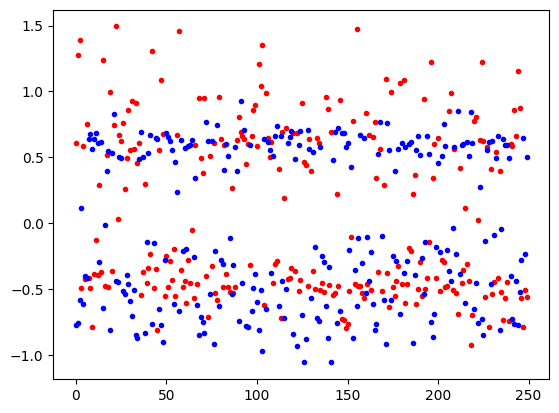

In [ ]:
plt.plot(data[:,0:1],'r.')
plt.plot(data[:,1:2],'b.')

In [ ]:
def plot_gaussian(mu, cov, color):
    eigenvalues, eig_vector = np.linalg.eig(cov)
    eigenvalues = np.sqrt(eigenvalues)
    ell = Ellipse(xy=mu, width=eigenvalues[0]*2, height=eigenvalues[1]*2,
                  angle=np.rad2deg(np.arccos(eig_vector[0, 0])), color=color)
    ell.set_facecolor('none')
    return ell

**b)**

In [ ]:

def gmm_e_step(X, means, devi, weights):
    N, D = X.shape
    K = len(weights)
    posteriors = np.zeros((N, K))
    for k in range(K):
        posteriors[:, k] = weights[k] * multivariate_normal.pdf(X, means[k], devi[k])  # scaled probability distribution each point based on the initiated mean and sigma(deviation)
    posteriors /= posteriors.sum(axis=1, keepdims=True)
    labels = np.argmax(posteriors, axis=1)   # get the label with the highest responsibility for each data point
    return posteriors, labels

def gmm_m_step(X, posteriors ):
    X_centered_points=[]
    N, D = X.shape
    K = posteriors .shape[1]
    weight = posteriors .mean(axis=0)       # compute the mean of matrix of posterior probabilities (pdf) across the rows
    mu = np.zeros((K, D))
    sigma = np.zeros((K, D, D))
    for k in range(K):
        Nk = posteriors [:, k].sum()        # (marginal probability)value representing the total posterior probability assigned to the k-th Gaussian component
        mu[k] = np.sum(X * posteriors [:, k, None], axis=0) / Nk    # update mean with the sum of the likelihood to belong to the k-th Gaussian component
        X_centered = X - mu[k]          # calculate the centered data
        sigma[k] = (X_centered.T @ (X_centered * posteriors [:, k, None])) / Nk     # updating the covariance matrix
        X_centered_points.append(X_centered)
    return weight, mu, sigma,X_centered_points

def gmm_em(X, K, n_iter=100):
    N, D = X.shape
    weight = np.ones(K) / K   # same weight initition
    mu = X[np.random.choice(N, K, replace=False)]
    sigma = np.array([np.eye(D)] * K)   # creating K matrices for categorizing the sigma for each group
    likelihoods = []
    for i in range(n_iter):
        postpro_mat, labels = gmm_e_step(X, mu, sigma, weight)
        weight, mu, sigma,_ = gmm_m_step(X, postpro_mat)
        log_likelihood = np.sum(np.log(np.sum(postpro_mat, axis=1)))
        likelihoods.append(log_likelihood)
    return weight, mu, sigma,postpro_mat, labels, likelihoods


In [ ]:
K=3
N, D = data.shape
T=np.array([np.eye(D)] * K)
weight = np.ones(K) / K
print(f'weight:{weight} \nsigma{T}')

weight:[0.33333333 0.33333333 0.33333333] 
sigma[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


In [ ]:
m=data[np.random.choice(N, K, replace=False)]
m

array([[-0.3881863 ,  0.60247972],
       [ 0.7627217 , -0.51519705],
       [-0.56501475,  0.64628142]])

In [ ]:
h1.mean()

0.003999999999999999

In [ ]:
weight, mu, sigma, post, labels, likely=gmm_em(X=data, K=3, n_iter=100)

In [ ]:
labels

array([0, 0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1,
       2, 2, 0, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 1, 2, 2, 2, 1, 0, 1,
       2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2,
       2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0,
       1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0, 1,
       2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 0, 0,
       0, 1, 2, 1, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 2, 1, 2])

In [ ]:
weight

array([0.08000013, 0.39937674, 0.52062314])

In [ ]:
sigma

array([[[ 0.00173457, -0.00030321],
        [-0.00030321,  0.01351837]],

       [[ 0.11984487, -0.00325501],
        [-0.00325501,  0.03074811]],

       [[ 0.19901947, -0.01455414],
        [-0.01455414,  0.01191339]]])

In [ ]:
mu

array([[-0.49860707, -0.20734344],
       [ 0.71393202, -0.65362253],
       [-0.26850642,  0.59787957]])

In [ ]:
likely

**(b)** plot the resulting mixture model (in the form of Gaussians in this two dimensional space).

In [ ]:
X=data

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))


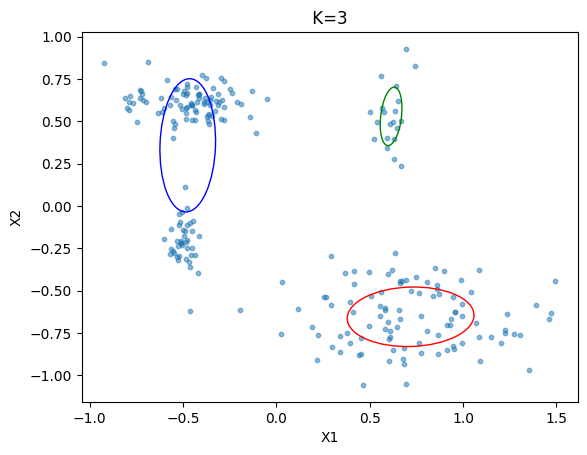

In [ ]:
K = 3
# weights, means, covariances = gmm_em(X, K)

# Create scatter plot of the data points
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green']
for i in range(K):
    ell=plot_gaussian(mu[i], sigma[i], colors[i])
    ax.add_artist(ell)
ax.set_title(' K=3 ')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

K=4

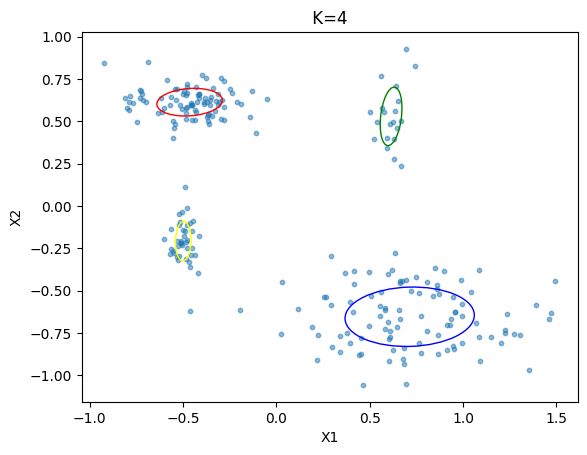

In [ ]:
K=4
weight_4, mu_4, sigma_4,gamma_4, labels_4,likely_4=gmm_em(X=data, K=4, n_iter=100)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green','yellow']
for i in range(K):
    ell=plot_gaussian(mu_4[i], sigma_4[i], colors[i])
    ax.add_artist(ell)
ax.set_title(' K=4 ')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

K=5


In the case where k=5 and there are two ellipsoids overlapping in one cluster, it is possible that the algorithm has converged to a suboptimal solution due to initialization or other factors. It may be worth trying different initialization strategies or running the algorithm for more iterations to see if a better solution can be found. Alternatively, it may be necessary to adjust the parameters of the algorithm or the data preprocessing to obtain better results.

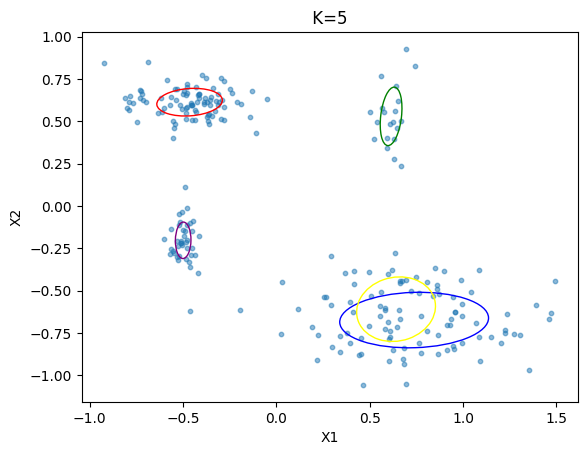

In [ ]:
k=5
weight_5, mu_5, sigma_5,gamma_5, labels_5,likely_5=gmm_em(X=data, K=k, n_iter=100)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green','yellow','purple']
for i in range(k):
    ell=plot_gaussian(mu_5[i], sigma_5[i], colors[i])
    ax.add_artist(ell)
ax.set_title(' K=5 ')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.show()

**c)**

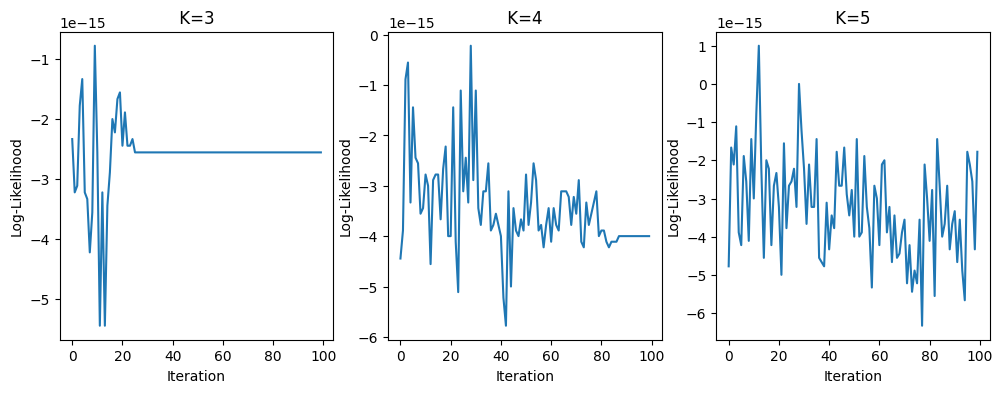

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(likely)
ax[0].set_title(' K=3 ')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Log-Likelihood')

ax[1].plot(likely_4)
ax[1].set_title(' K=4 ')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Log-Likelihood')

ax[2].plot(likely_5)
ax[2].set_title(' K=5 ')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Log-Likelihood')

plt.show()

d)

In [ ]:
def calculate_bic(X, weights, means, covariances, log_likelihood):
    N, D = X.shape
    K = len(weights)
    num_params = K * (D + D*(D+1)//2 + 1) - 1  # Number of parameters in the GMM
    bic = -2 *  (np.array(log_likelihood) * 1e6) + num_params * np.log(N)
    return bic


In [ ]:
BIC_3=calculate_bic(X, weight, mu, sigma, likely[-1])
BIC_3

93.8648356087652

In [ ]:
BIC_4=calculate_bic(X, weight_4, mu_4, sigma_4, likely_4[-1])
BIC_4

126.99360111882527

In [ ]:
BIC_5=calculate_bic(X, weight_5, mu_5, sigma_5, likely_5[-1])
BIC_5

160.12236662155786

In [ ]:
weight

array([0.39937674, 0.52062314, 0.08000013])

In [ ]:
weight_4

array([0.4012531 , 0.0800001 , 0.35999986, 0.15874694])

In [ ]:
weight_5

array([0.07999922, 0.11762937, 0.15686979, 0.36000001, 0.2855016 ])

**3)** a dataset EnergyConsumptionData of 500 points in input-output pairs (i.e., $x_1, y_1, x_2, y_2, . . ., x_{500}, y_{500}$).

In [ ]:
#

def read_data():
    workbook = openpyxl.load_workbook('/content/drive/MyDrive/Uni/Aston/Coursework/Probabilistic Modeling/EnergyConsumptionData.xlsx')
    sheet = workbook.active
    columnA_values = [cell.value for cell in sheet['A'][0:]]
    columnB_values = [cell.value for cell in sheet['B'][0:]]
    list_dataA = [int(value) for value in columnA_values if value]
    list_dataB = [float(value) for value in columnB_values if value]

    data=pd.concat([pd.DataFrame(list_dataA),pd.DataFrame(list_dataB)],axis=1)
    data.columns=['X', 'Y']
    return data
df=read_data()
df

,X,Y
0,1,0.206510
1,2,0.487440
2,3,0.226630
3,4,0.682970
4,5,0.767300
...,...,...
495,496,-0.034721
496,497,-0.137870
497,498,-0.322240
498,499,-0.131280


**b)**

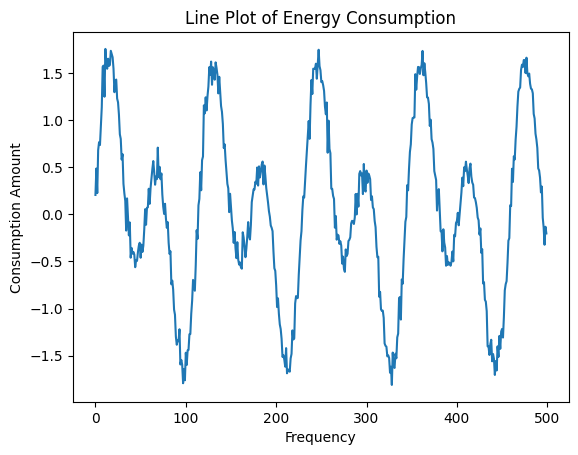

In [ ]:
df['Y'].plot()
plt.xlabel('Frequency')
plt.ylabel('Consumption Amount')
plt.title('Line Plot of Energy Consumption')
plt.show()


In [ ]:
# energy_data = df['consumption'].values
# frequency_data = np.fft.fft(energy_data)
# frequency_data
x=df['X']
y=df['Y']
# Calculate the FFT of the data
fft_y = np.fft.fft(y)
dominant_freq_index = np.argmax(np.abs(fft_y))
dominant_freq = np.fft.fftfreq(len(y))[dominant_freq_index]


amplitude = np.ptp(y)

# Calculate the period of the waveform
period = len(y) / dominant_freq

# Calculate the phase of the waveform
reference_waveform =amplitude* np.sin(((2 * np.pi)/period) * dominant_freq * x)
correlation = np.correlate(y, reference_waveform, mode='same')
phase = np.argmax(correlation) / len(y) * 360

# Print the results
print('Dominant frequency:', dominant_freq)
print('Amplitude:', amplitude)
print('Period:', period)
print('Phase:', phase)

Dominant frequency: 0.018000000000000002
Amplitude: 3.5688
Period: 27777.777777777774
Phase: 10.799999999999999


In [ ]:
fft = np.fft.fft(y)
freqs = np.fft.fftfreq(len(y))
idx = np.argmax(np.abs(fft))
freq = freqs[idx]
amp = np.abs(fft[idx])
print('frequency:', freq)

frequency: 0.018000000000000002


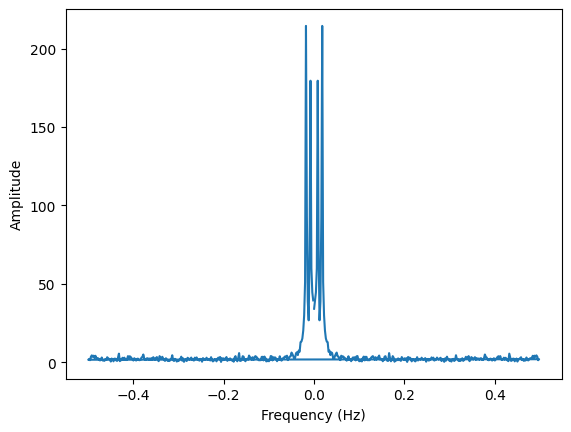

In [ ]:
plt.plot(freqs, np.abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
X=df['X']#.iloc[:,0]
Y=df['Y']#.iloc[:,1]
X_train,X_test,y_train, y_test= train_test_split(X,Y,test_size=0.35,shuffle=False)

**c)**
**My Sample Kernel**
model the data use the kernel that combines two components i = 1, 2.
kernel :
$$
\begin{aligned}
C(x, x'; \Theta) = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right],
\end{aligned}
$$

the gradients with respect to $\theta$, $\lambda_i$, and $r_i$:

Gradient with respect to $\theta$:
\begin{align}
\frac{\partial C(x, x'; \Theta)}{\partial \theta} = \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}\left(x - x'\right)\right)}{r_i}\right)^2\right]
\end{align}

Gradient with respect to $\lambda_i$:
\begin{align}
\frac{\partial C(x, x'; \Theta)}{\partial \lambda_i} = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right] \left(\frac{\pi \left(x - x'\right) \cos\left(\frac{\pi}{\lambda_i}\left(x - x'\right)\right)}{\lambda_i^2 r_i^2}\right)
\end{align}

Gradient with respect to $r_i$:
\begin{align}
\frac{\partial C(x, x'; \Theta)}{\partial r_i} = \theta \exp\left[-\frac{1}{2} \sum_{i=1}^2 \left(\frac{\sin\left(\frac{\pi}{\lambda_i}(x - x')\right)}{r_i}\right)^2\right] \left(\frac{\sin\left(\frac{\pi}{\lambda_i}\left(x - x'\right)\right)}{r_i^3}\right)
\end{align}

In [ ]:


class GaussianProcess:
    def __init__(self, theta= 3.5688 , lambda_1=-0.001, lambda_2=0.1, r_1=0.2802, r_2=0.2898):
        self.theta = theta
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.r_1 = r_1
        self.r_2 = r_2

    def kernel(self, x1, x2):
        sin_term_1 = np.sin(np.pi / self.lambda_1 * (x1 - x2)) / self.r_1
        sin_term_2 = np.sin(np.pi / self.lambda_2 * (x1 - x2)) / self.r_2
        kernel_value = self.theta * np.exp(-0.5 * (sin_term_1 ** 2 + sin_term_2 ** 2))
        return kernel_value

    def fit(self, X, y,noise=1e-8):
        self.X_train = X
        self.y_train = y
        n = len(X)
        self.K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                self.K[i, j] = self.kernel(X[i], X[j])
        self.K += noise * np.eye(n)

    def predict(self, X_star):
        n = len(self.X_train)
        m = len(X_star)
        K_star = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                K_star[i, j] = self.kernel(X_star[i], self.X_train[j])
        K_star_star = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                K_star_star[i, j] = self.kernel(X_star[i], X_star[j])
        K_inv = np.linalg.inv(self.K)
        y_mean = np.dot(np.dot(K_star, K_inv), self.y_train)
        y_cov = K_star_star - np.dot(np.dot(K_star, K_inv), K_star.T)
        return y_mean, y_cov



In [ ]:
y_noise = y_train + np.random.normal(loc=0, scale=0.1, size=X_train.shape[0])

X_=X_train.reset_index(drop=True)
y_=y_train.reset_index(drop=True)
gp = GaussianProcess(theta= 3.5688 , r_1=1.5556, r_2=3.6,lambda_1=55.55, lambda_2=113)

gp.fit(X_, y_noise.reset_index(drop=True))
y_mean, y_cov = gp.predict(X_test.reset_index(drop=True))

In [ ]:
y_cov

array([[ -4.35572772,  -4.37118072,  -4.39080629, ...,  -6.11365831,
         -6.07274146,  -6.02124766],
       [ -6.27162894,  -6.26521515,  -6.28296819, ...,  -9.6454234 ,
         -9.44808909,  -9.22874142],
       [ -3.28294666,  -3.15658574,  -3.04539494, ...,  -8.04625007,
         -8.08219275,  -8.0894171 ],
       ...,
       [ -1.98426343,  -1.97445078,  -1.98333157, ...,  -6.23059522,
         -6.16896289,  -6.09029032],
       [ -7.40278583,  -7.36026581,  -7.34336759, ..., -12.06865247,
        -11.96031554, -11.83228007],
       [ 40.02012055,  39.47250415,  38.93059313, ...,  45.24076116,
         45.77885697,  46.23825587]])

In [ ]:
y_mean

array([-1.26274940e+01, -3.80701606e+01, -7.58468733e+01, -1.30899507e+02,
       -2.03141738e+02, -2.77463472e+02, -3.59297393e+02, -4.37445169e+02,
       -5.17607202e+02, -5.87654663e+02, -6.47014508e+02, -6.92775799e+02,
       -7.23096081e+02, -7.28672265e+02, -7.06751365e+02, -6.56835853e+02,
       -5.88375603e+02, -5.06875482e+02, -3.99534188e+02, -2.87924527e+02,
       -1.76748382e+02, -6.14031018e+01,  3.44389246e+01,  1.14970667e+02,
        1.77154958e+02,  2.12637043e+02,  2.24796929e+02,  2.09398368e+02,
        1.77120602e+02,  1.24910940e+02,  6.04232988e+01, -1.62633353e+01,
       -9.98683572e+01, -2.02622929e+02, -3.08922848e+02, -4.28238962e+02,
       -5.52016597e+02, -6.77285892e+02, -7.90141218e+02, -8.94660268e+02,
       -9.85208407e+02, -1.05547024e+03, -1.10534498e+03, -1.13436913e+03,
       -1.14584658e+03, -1.13759444e+03, -1.10615073e+03, -1.06071954e+03,
       -9.96507987e+02, -9.17720379e+02, -8.22558328e+02, -7.17341027e+02,
       -6.04801988e+02, -

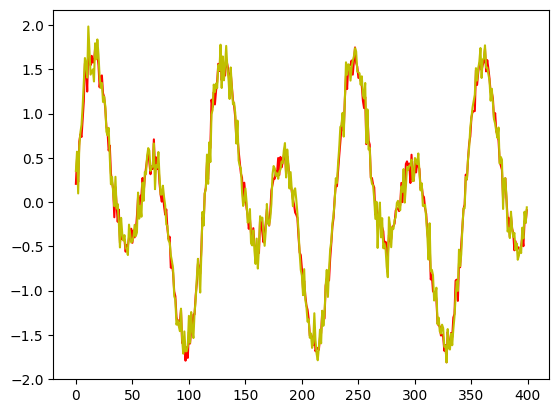

In [ ]:
plt.plot(y_train,'r-', label='True Values')
plt.plot(y_noise, 'y-', label='Predictions')

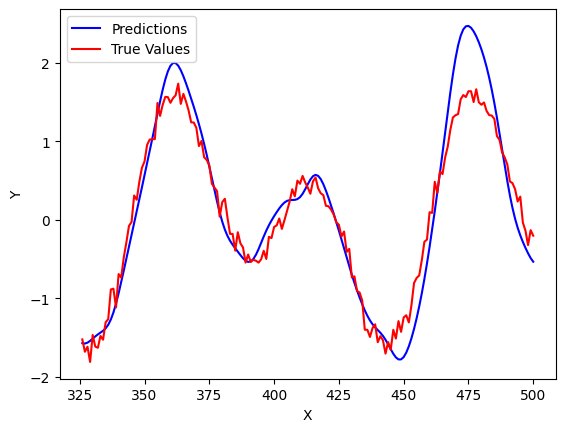

In [ ]:

plt.plot(X_test, y_mean, 'b-', label='Predictions')

# Plot the true values
plt.plot(X_test, y_test, 'r-', label='True Values')

# Fill the area between the upper and lower bounds of the confidence interval
# plt.fill_between(X_test.squeeze(), y_mean.squeeze() - 2*np.sqrt(np.diag(y_cov)),
#                  y_mean.squeeze() + 2*np.sqrt(np.diag(y_cov)), alpha=0.2)

# Set the labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

**3) ii**

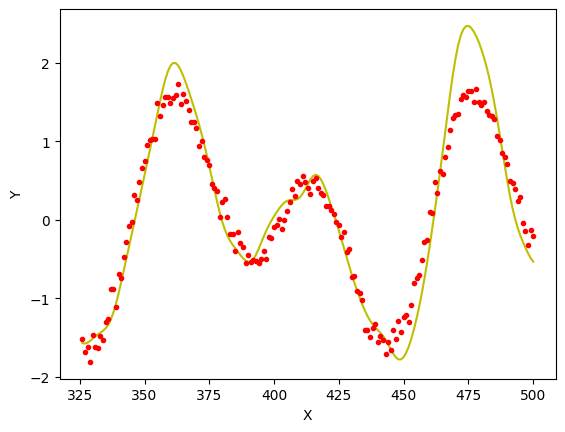

In [ ]:
y_noise = y_train + np.random.normal(loc=0, scale=0.1, size=X_train.shape[0])

X_=X_train.reset_index(drop=True)
y_=y_train.reset_index(drop=True)
gp_ii = GaussianProcess(theta= 0.7369 , r_1=0.2802, r_2=0.2898,lambda_1=-0.2278, lambda_2=-0.2278)

gp_ii.fit(X_, y_noise.reset_index(drop=True))
y_pred_ii, y_cov_ii = gp.predict(X_test.reset_index(drop=True))

plt.plot(X_test, y_pred_ii, 'y-', label='Predictions')
plt.plot(X_test, y_test, 'r.', label='True Values')

plt.xlabel('X')
plt.ylabel('Y')

plt.show()

**3) iii**


In [ ]:
n = len(y)
sq_diff = np.square(y_test - y_mean)
E = np.sum(sq_diff) / n
print('expected quadratic error:',E)

expected quadratic error: 0.03452871783352929


In [ ]:
from sklearn.metrics import mean_squared_error
mse= mean_squared_error(y_test, y_mean)
print('mean squared error:',mse)


mean squared error: 0.09865347952436938


**c) iv**

In [ ]:


gp = GaussianProcess()
gp.fit(X_, y_noise)
x_star = np.array([[150]])
y_mean, y_cov = gp.predict(x_star)
expected_y = y_mean[0]
print(f'expected:{expected_y} \ntrue value:{y_[150]}')

expected:0.07505809317862024 
true value:0.07814


**Gaussian model with default setting**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr.fit(X_.values.reshape(-1, 1), y_.values.reshape(-1, 1))
y_pred_in = gpr.predict(X_test.values.reshape(-1, 1))


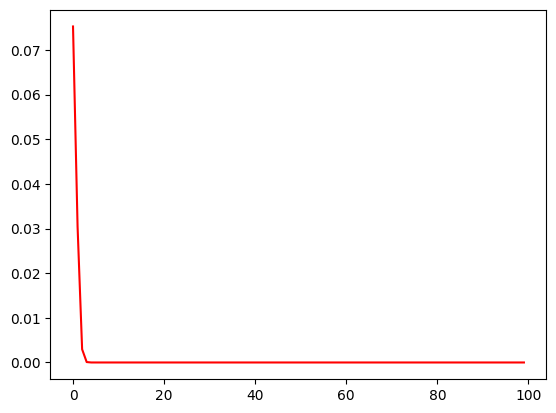

In [ ]:
# y_pred_in
plt.plot(y_pred_in,'r-', label='True Values')

**Gaussian model with exponential sine kernel**

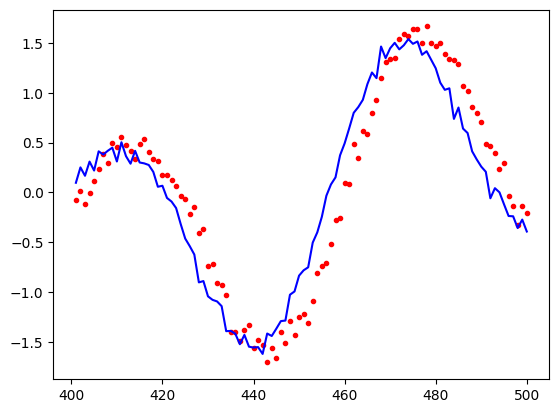

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared

# # Create some example data
# x = np.linspace(0, 10, 100)
# y = np.sin(x) + np.random.normal(0, 0.1, len(x))

# Define the kernel
kernel = ExpSineSquared(length_scale=1.0, periodicity=27777.777777777774)

# Define the Gaussian process regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

# Fit the model to the data
gp.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

# Predict values for a range of inputs
# x_pred = np.linspace(-1, 11, 200)
y_pred, y_std = gp.predict(X_test.values.reshape(-1, 1), return_std=True)

# Plot the results
plt.plot(X_test,y_test, 'r.', label='Observations')
plt.plot(X_test, y_pred, 'b-', label='Prediction')
# plt.fill_between(x_pred, y_pred - y_std, y
